# Введение

Несмотря на то, что товары могут иметь одинаковые текстовые описания при разных изображениях и наоборот, в рамках тестового задания было решено сосредоточиться исключительно на текстовой информации. Это позволяет упростить модель и структуру данных, не снижая при этом информативности.

Для реализации семантического сравнения товарных описаний была выбрана модель SBERT, так как она удовлетворяет ключевым требованиям тестового задания — использовать метод, основанный на косинусном сходстве, и пригодный для задачи дедубликации. SBERT специально адаптирован для получения плотных векторных представлений текстов и использует сиамскую архитектуру, что позволяет эффективно сравнивать пары объектов. Метод позволяет заранее вычислить эмбеддинги всех карточек и производить масштабируемый поиск схожих объектов, что делает его полезным для задач в e-commerce.


#Установка зависимостей

In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 108.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2


# Настройка модели sbert на русском языке
## Локальное использование модели
Страница: https://huggingface.co/ai-forever/sbert_large_nlu_ru


In [1]:

from transformers import pipeline

pipe = pipeline("feature-extraction", model="ai-forever/sbert_large_nlu_ru")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

Для использования модели также необходимы следующие функции:

In [3]:
import torch

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [4]:
def get_embedding(sentence: str):
    encoded_input = tokenizer([sentence], padding=True, truncation=True, max_length=1, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return sentence_embeddings.cpu().numpy()

# Набор данных
Для демонстрации будет использован искусственный датасет.
Датасет содержит 40 записей с описаниями товаров.

| Столбец     | Тип данных | Описание                                                                 |
|-------------|------------|--------------------------------------------------------------------------|
| Категория   | string     | Название категории товара (например, "Смартфон", "Кружка", "Футболка")   |
| Описание    | string     | Краткое текстовое описание товара (предложение на русском языке)     |

**Особенности:**
- В датасете содержатся **10 кластеров семантических дубликатов** (по 3–4 описания на категорию).
- **6 записей** являются **уникальными** и не имеют семантических дубликатов.
- Используемый разделитель в CSV — **`;`** (точка с запятой).
- Кодировка файла — **UTF-8 с BOM**, для корректного открытия в Excel.

In [ ]:
import pandas as pd

product_df = pd.read_csv('/ecommerce_products_ru.csv', sep=';', encoding='utf-8-sig')
product_df.head(10)

,Категория,Описание
0,Газированная вода,"Газированная вода с легким вкусом лимона, осве..."
1,Газированная вода,Освежающий напиток с пузырьками на основе мине...
2,Газированная вода,"Питьевая вода, насыщенная углекислым газом, с ..."
3,Газированная вода,"Прохладительный напиток из воды, в том числе м..."
4,Наушники,Беспроводные наушники с шумоподавлением и заря...
5,Наушники,Компактные Bluetooth-наушники с активным шумоп...
6,Наушники,Легкие наушники без проводов с чехлом и функци...
7,Наушники,Наушники True Wireless с ANC и поддержкой сенс...
8,Футболка,Мягкая хлопковая футболка с коротким рукавом и...
9,Футболка,Базовая футболка из натурального хлопка с удоб...


# Алгоритм

*   Получение embedding предложений для каждой записи.
*   Вычисление попарного косинусного сходства между товарами.
*   Определение дубикатов с помощью порового значения.
*   Сравнение с эталонным определением дубликатов.

In [6]:
import numpy as np

## Получение embedding предложений для каждой записи

In [36]:
embeddings: pd.Series = product_df['Описание'].apply(get_embedding)
embeddings[:5]

,Описание
0,"[[0.07237565, -0.72173464, -0.7560015, 0.56641..."
1,"[[0.32498953, -0.58546084, -0.6406336, 0.52050..."
2,"[[0.48809898, -0.7039036, -0.09518419, 0.45845..."
3,"[[0.48472172, -0.5096344, -0.69157445, 0.55375..."
4,"[[-0.19405903, -0.45766026, -0.10363116, -0.29..."


## Вычисление попарного косинусного сходства между товарами

Функция для получения косинусного сходства между парой embedding векторов:

In [10]:
def calculate_cosine_similarity(a: np.ndarray, b: np.ndarray) ->np.ndarray:
    vector_a = a.flatten()
    vector_b = b.flatten()

    dot_product = np.dot(vector_a, vector_b)
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0

    cosine_similarity = dot_product / (magnitude_a * magnitude_b)
    return cosine_similarity

Функция для получения матрицы, которая содержит в себе попарные косинусные сходства:

In [11]:
def get_cosine_similarity_matrix(embeddings: np.ndarray) -> np.ndarray:
    N = len(embeddings)
    cosine_similarity_matrix = np.zeros((N, N), dtype=float)
    for i, value_i in embeddings.items():
        for j, value_j in embeddings.items():
            if cosine_similarity_matrix[i,j] != 0:
                continue
            if i == j:
                cosine_similarity_matrix[i,j] = 0
            else:
                cosine_similarity_matrix[i,j] = calculate_cosine_similarity(value_i, value_j)
                cosine_similarity_matrix[j,i] = cosine_similarity_matrix[i,j]

    return cosine_similarity_matrix

Получим матрицу со значениями косинусного сходства

In [14]:
cosine_similarity_matrix = get_cosine_similarity_matrix(embeddings)
cosine_similarity_matrix

array([[0.        , 0.89315468, 0.91062307, ..., 0.68914568, 0.5551911 ,
        0.52121288],
       [0.89315468, 0.        , 0.83470398, ..., 0.70363235, 0.54291594,
        0.57904291],
       [0.91062307, 0.83470398, 0.        , ..., 0.76915252, 0.54609567,
        0.56015444],
       ...,
       [0.68914568, 0.70363235, 0.76915252, ..., 0.        , 0.68032992,
        0.71577263],
       [0.5551911 , 0.54291594, 0.54609567, ..., 0.68032992, 0.        ,
        0.79676729],
       [0.52121288, 0.57904291, 0.56015444, ..., 0.71577263, 0.79676729,
        0.        ]])

## Определение дубликатов с помощью порового значения

Функция для определения дубликатов:

In [37]:
def get_duplicate_pairs_matrix(cosine_similarity_matrix: np.ndarray, threshold: float=0.75) ->np.ndarray:
    duplicate_pairs_matrix = np.zeros_like(cosine_similarity_matrix)
    N = duplicate_pairs_matrix.shape[0]
    for i in range(N):
        for j in range(i+1, N):
            if cosine_similarity_matrix[i, j] >= threshold:
                duplicate_pairs_matrix[i, j] = 1
                duplicate_pairs_matrix[j, i] = 1
    return duplicate_pairs_matrix

Получим матрицу предсказаний, где значение 1 в ячейке (i,j) означает, что i объект семантически схож с j объектом:

In [16]:
pred_matrix = get_duplicate_pairs_matrix(cosine_similarity_matrix, threshold=0.85)

Будем считать, что если объекты входят в одну категорию, то они семантически схожи.
Функция для создания матрицы истинных дубликатов на основе категории:

In [18]:
def get_truth_matrix(product_df: pd.DataFrame, category_col: str='Категория') -> np.ndarray:

    categories = product_df[category_col].values
    N = len(categories)
    y_true = np.zeros((N, N), dtype=int)

    for i in range(N):
        for j in range(i+1, N):
            if categories[i] == categories[j]:
                y_true[i, j] = 1
                y_true[j, i] = 1

    # Обнуляем диагональ: объект сам себе не дубликат
    np.fill_diagonal(y_true, 0)

    return y_true

In [19]:
truth_matrix = get_truth_matrix(product_df)

# Результаты

## Значения метрик качества предсказания

Получим значения precision, recall и F1-меру для предсказанных пар:

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score



y_true_flat = truth_matrix.flatten()
y_pred_flat = pred_matrix.flatten()

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

In [38]:
print('Точность:', precision)
print('Полнота:', recall)
print('F1-мера:', f1)

Точность: 0.8113207547169812
Полнота: 0.8958333333333334
F1-мера: 0.8514851485148515


Модель демонстрирует хорошее качество предсказаний: ей удаётся обнаружить почти все дубликаты товаров (recall ≈ 90%), сохраняя при этом приемлемый уровень точности (precision ≈ 81%). F1-мера, равная ≈ 85%, подтверждает, что модель сбалансирована и подходит для задачи семантической дедубликации.

## Визуальное отображение результатов

Функция для отображения матрицы со значениями косинусного сходства:

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(matrix:np.ndarray, title:str='Heatmap', cmap='viridis', annot:bool=False):

    plt.figure(figsize=(matrix.shape[0]/2, matrix.shape[0]/2))
    sns.heatmap(matrix, vmin=0, vmax=1, cmap=cmap, square=True, cbar=True, annot=annot)
    plt.title(title)
    plt.xlabel("Объекты")
    plt.ylabel("Объекты")
    plt.tight_layout()
    plt.show()

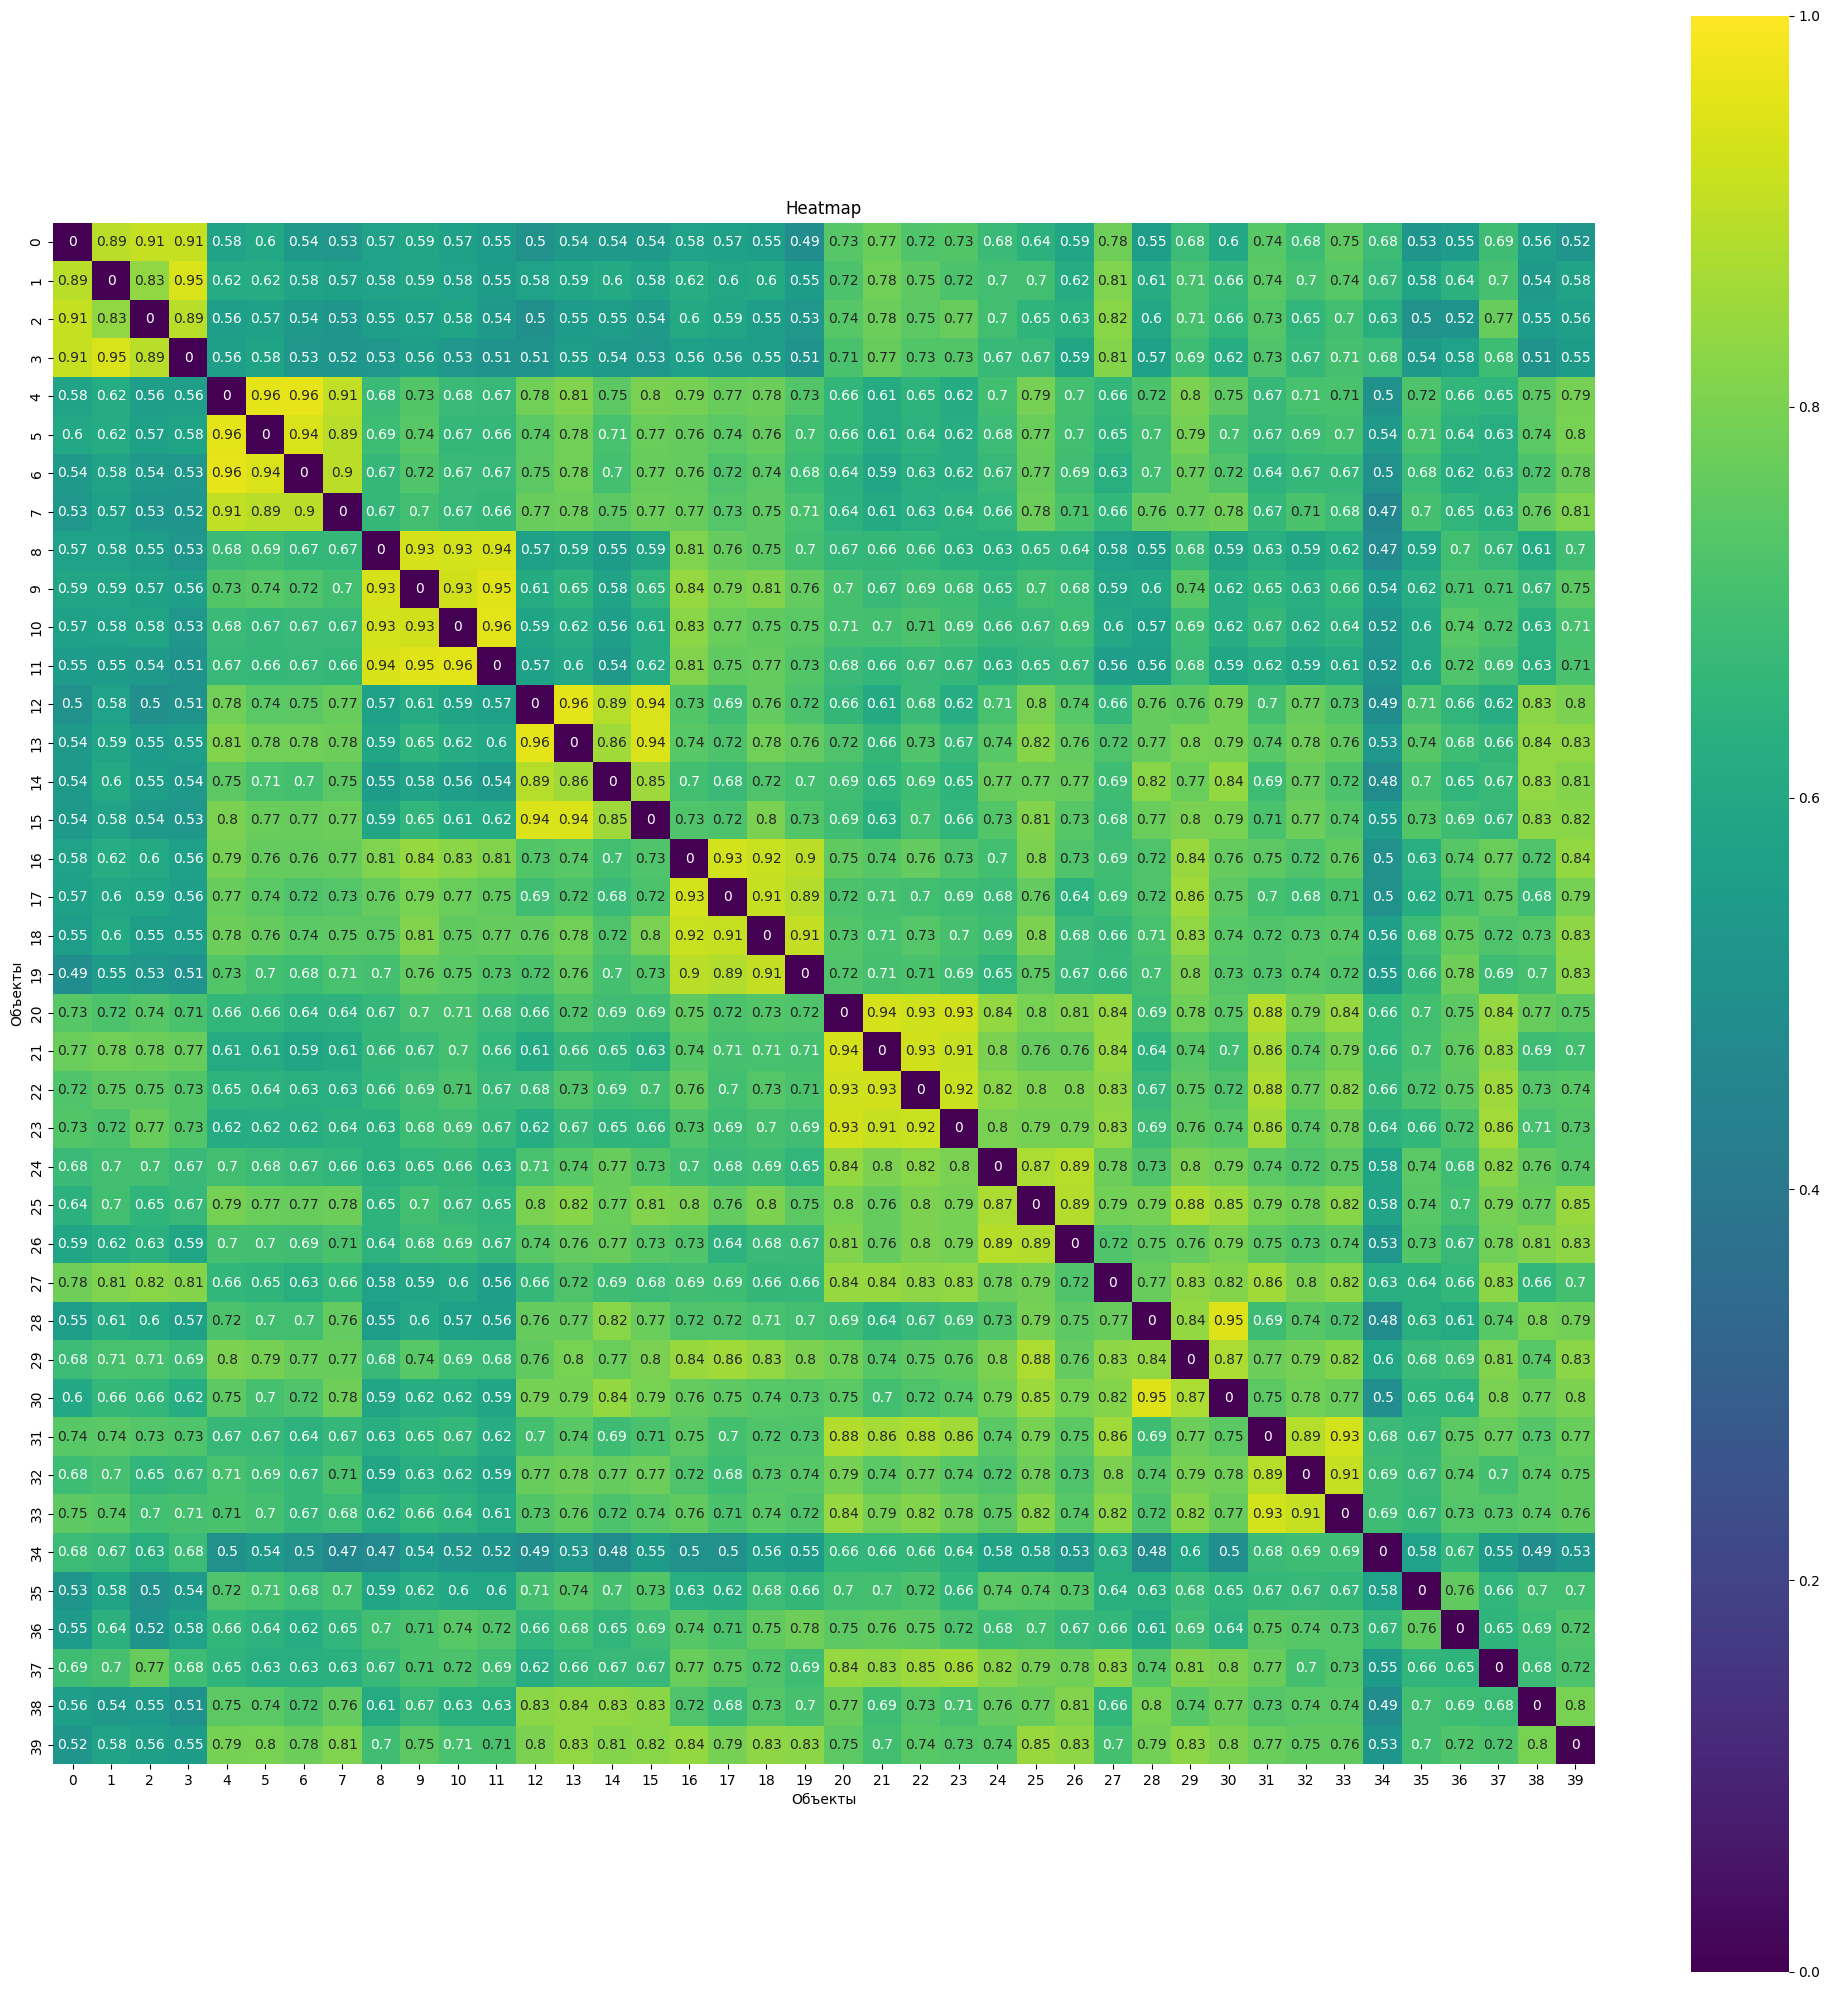

In [25]:
plot_heatmap(cosine_similarity_matrix, annot=True)

Из этой матрицы можно увидеть, что меняя значение порога можно влиять на precision/recall, в зависимости от поставленной задачи и критичности различных ошибок.

Посмотрим где конкретно TP/TN/FP/FN типы предсказаний.

Для этого необходимо получить матрицу, содержащую 4 различных значения, которые кодируют варианты:

In [39]:
def combine_prediction_and_truth(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

    result = np.full_like(y_true, fill_value=np.nan, dtype=float)

    is_true  = y_true == 1
    is_false = ~is_true

    is_pred  = y_pred == 1
    not_pred = ~is_pred

    result[is_true & is_pred] = 1   # TP
    result[is_false & not_pred] = 0 # TN
    result[is_false & is_pred] = 2  # FP
    result[is_true & not_pred] = -1 # FN

    return result

In [26]:
y_combined = combine_prediction_and_truth(truth_matrix, pred_matrix)

Функция для отображения такой матрицы:

In [34]:
import matplotlib.patches as mpatches

def plot_confusion_heatmap(matrix: np.ndarray, title: str ='TP/TN/FP/FN Heatmap'):

    # FN, TN, TP, FP
    cmap_dict = {-1: 0, 0: 1, 1: 2, 2: 3}
    palette = ['orange', '#c0d6e4', 'green', 'red']
    matrix_mapped = np.vectorize(lambda x: cmap_dict.get(x, np.nan))(matrix)

    plt.figure(figsize=(matrix.shape[0]/2, matrix.shape[0]/2))
    sns.heatmap(matrix_mapped, cmap=palette, cbar=False, square=True)
    plt.title(title, fontsize=16)
    plt.xlabel("Объекты")
    plt.ylabel("Объекты")


    legend_labels = {
        'FN (-1)': 'orange',
        'TN (0)':  '#c0d6e4',
        'TP (1)':  'green',
        'FP (2)':  'red'
    }
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
    plt.legend(
        handles=legend_patches,
        loc='upper right',
        bbox_to_anchor=(1.3, 1.0),
        title='Классы',
        prop={'size': 16},
        title_fontsize=16
        )

    plt.tight_layout()
    plt.show()

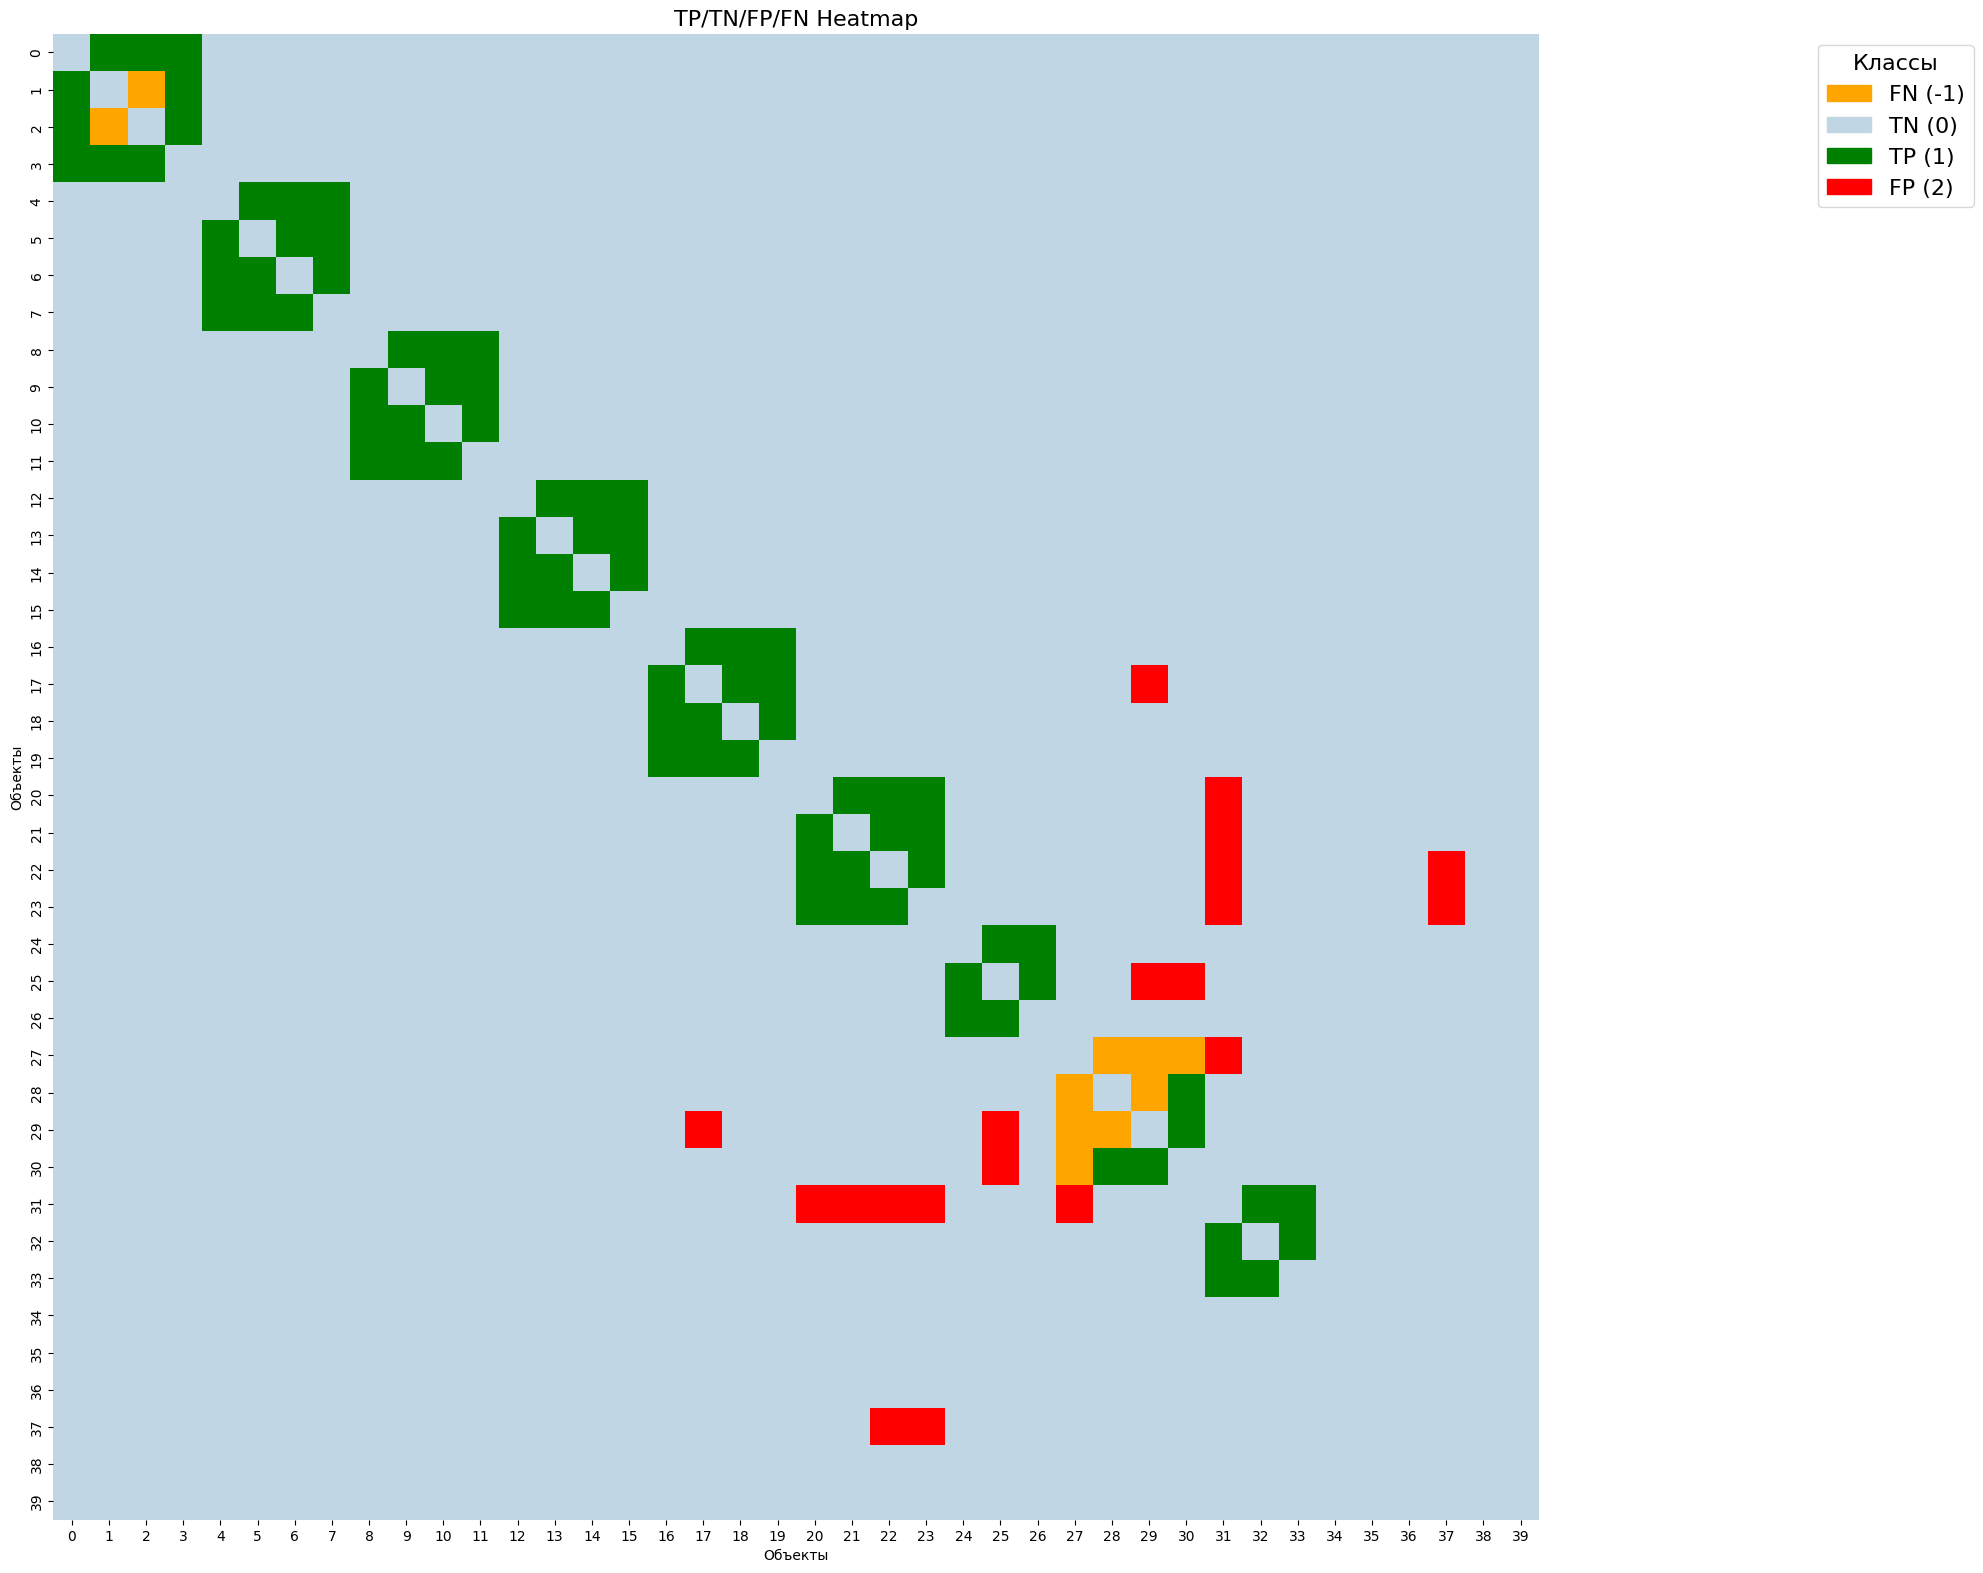

In [35]:
plot_confusion_heatmap(y_combined)

Из матрицы видно, что записи с 25 по 31 записи содержат ошибки связанных с друг с другом и записями 16-25, для заключения точных выводов посмотрим на текст, который они содержат:

In [44]:
product_df.iloc[16:32]

,Категория,Описание
16,Рюкзак,Рюкзак с отделением для ноутбука и водоотталки...
17,Рюкзак,Городской рюкзак с карманом под ноутбук и защи...
18,Рюкзак,Практичный рюкзак с мягкой спинкой и отсеком д...
19,Рюкзак,Универсальный рюкзак для города с отделением п...
20,Кружка,"Керамическая кружка с ручкой, объём 330 мл, по..."
21,Кружка,"Белая кружка из керамики, объём 330 мл, для го..."
22,Кружка,Чашка объёмом 330 мл из термостойкой керамики.
23,Кружка,"Кружка классической формы, объём 330 мл, устой..."
24,Настольная лампа,Настольная лампа с гибким основанием и тёплым ...
25,Настольная лампа,Светильник настольный с поворотной ножкой и мя...


Из текста видно, что тексты имеют пересечения по словам, например:
31 запись содержит слова "чаша" и "литры", и получается, что записи, которые содержат эти слова (а именно 20-23 и 27) определяются алгоритмом как дубликаты. Для решения данной проблемы можно, например, повысить значения порога.

# Заключение
В рамках данной работы была реализована и протестирована система выявления семантических дубликатов товарных описаний на русском языке с использованием модели SBERT. Подход основан на получении эмбеддингов предложений и вычислении косинусного сходства между ними.

Система показала следующие результаты качества:

*   Точность (Precision): 81.1%
*   Полнота (Recall): 89.6%
*   F1-мера: 85.1%

Эти значения демонстрируют хорошую способность модели находить дубликаты (высокая полнота) при умеренном количестве ложных срабатываний (точность выше 80%).

Также, для оценки результатов были построены тепловые карты косинусных сходств и матрица ошибок (TP, FP, FN, TN).